# [オンライン開催]セキュリティから学ぶ機械学習第5回
今回は、機械学習がシステム化されているものに対して攻撃者側が攻撃する手段のサンプルをいくつか見ていきます  
【引用元: [詳細解説 ©Mitsui Bussan Secure Directions, Inc. All rights reserved.](https://www.mbsd.jp/aisec_portal/detail_attack.html)】

## Section0. 概要
これまでの勉強会で、いくつかのサンプルで機械学習を用いてセキュリティへの問題を解くことができました。一方で、機械学習が実装されたシステムそのもののセキュリティを考慮する必要性があります。  
  
機械学習システムには、

*   データを収集する処理
*   データを整形する処理
*   データをもってモデルを学習するプロセス
*   学習済みモデルから新たなデータに対する判断結果を得るプロセス
*   学習済みモデルをバージョン管理する、データをバージョン管理するプロセス

などが挙げられます。  

今回は特に、モデルの学習および学習済みモデルの運用に関する攻撃手法を見ていきます



### Section0-1. 攻撃の種類
【参考: [第3回 ～AIを乗っ取る攻撃–学習データ汚染-～](https://jpsec.ai/attack-to-hijack-ai/)】



*   **転移攻撃**  
学習済みのモデルから訓練データに関する情報やモデルのパラメータ情報を搾取する攻撃。モデルの機密性に対する脅威になります。例えば、顔認識システムがどんな顔写真のデータを使って、学習されているかの情報を特定する攻撃などがあります。
*   **回避攻撃**  
学習済みのモデルに正しく分類されていないデータを生成する攻撃。モデルの完全性に対する脅威となります。例えば、顔認識システムに、ある人物の顔写真を別人物の画像であると判定されるように、顔写真データに大きなノイズを与える攻撃などがあります。
*   **汚染攻撃**  
学習中または学習済みのモデルに不正なデータを与えて、モデルの精度を低下させる攻撃。モデルの完全性、または可用性に対する脅威となります。例えば、顔認識システムに、ある人物の顔写真を別人物の画像であると判定されるように、顔写真データに大きなノイズを与える攻撃などがあります。例えば、顔認識システムに、ある人物の顔写真を別人物の画像であると判定されるように、顔写真データに大きなノイズを与える攻撃などがあります。

転移攻撃と回避攻撃は、学習済みモデルに対する攻撃となります。したがって、モデルの学習そのものには攻撃できないものであり、学習済みモデルがクラウドサービス上で公開されている場合に、ユーザーがAPI経由で学習済みモデルが実装されたシステムにアクセスする際に、攻撃者は不正なユーザーとしてシステムに攻撃を行います。  
  
一方、汚染攻撃は学習中のプロセスそのものに干渉してきます。したがって、攻撃者はモデルの学習プロセスに介入できる攻撃者であるといえます。

*   **ホワイトボックス攻撃**  
モデルのアーキテクチャやパラメータが攻撃者にとって既知である場合の、攻撃となります。例えば、シリアライズされたpickleファイルなどが攻撃者の手元にあり、ライブラリを通じて操作できるような状況が挙げられます。
*   **ブラックボックス攻撃**  
モデルのアーキテクチャやパラメータが攻撃者にとって未知である場合の、攻撃なります。例えば、攻撃者は手探りで機械学習システムの中の攻撃対象を特定して攻撃手法を実現させなければならない状況が挙げられます。






### Section0-2. 攻撃に利用できること（）


*   論文をもとに攻撃手法を再構築して攻撃する
*   論文の著者が公開している実装を利用して攻撃する
*   複数の攻撃手法の実装を取りまとめたライブラリを利用して攻撃する

今回は、論文をベースにして攻撃手法を構築する（難しい＆時間がかかる）のではなく、ライブラリに依存した攻撃についてサンプルを見ていきます。

機械学習システムへの攻撃に利用できるライブラリとしては、[Clever Hans](https://github.com/cleverhans-lab/cleverhans), [Foolbox Native](https://foolbox.readthedocs.io/en/stable/), [ART(Adversarial Robustness Toolbox)](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/)などがあります。



## Section1. 各種攻撃のサンプル
### Section1-1. ARTを用いた、攻撃のフロー


*   データセットのロード
*   モデルの学習
*   モデルのラッパーのインスタンス作成
*   攻撃手法のインスタンス作成
*   攻撃の実行



In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
# 攻撃手法をインポートする
# 転移攻撃の場合は、art.attacks.inference
# 回避攻撃の場合は、art.attacks.evasion
# 汚染攻撃の場合は、art.attacks.poisoning
from art.attack.evasion import ...

# モデルのラッパーをインポートする
#学習タスクに応じて、classification, encoding, object_detectionなどのモジュールがある
from art.estimators.classification import ...

# モデルのロード
model = ...

# ラッパーのインスタンスを初期化する
classifier = ...

# 攻撃のインスタンスを初期化する
attack = ... (classifier=classifier, ...)

# 攻撃の実行
# 転移攻撃の場合は、infer, extract, 回避攻撃の場合は、generate
# 汚染攻撃の場合、poisonというメソッドから攻撃を実行できる
... = attack.generate(...)

### Section1-2. Copycat CNN
畳み込みニューラルネットを対象としてモデルの抽出攻撃手法になります。


*   適当なデータを攻撃対象のモデルに与え、その出力をラベルとして擬似データセットを生成する
*   擬似データセットを学習させて、攻撃対象と同じように振る舞う代替モデルを作成する





畳み込みニューラルネットを定義して、そこにARTのラッパーを与える

In [ ]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam

# ラッパーおよびユーティリティをインポートする
from art.estimators.classification.keras import KerasClassifier
from art.utils import load_mnist

# MNISTデータセットをロードする
(X_train, y_train), (X_test, y_test), \
    min_pixel_value, max_pixel_value = load_mnist()

nb_classes=10

# 攻撃対象のモデルを定義する
model = Sequential()
model.add(Conv2D(1,kernel_size=(7, 7), activation='relu', 
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

victim_classifier = KerasClassifier(model,
                                    clip_values=(0, 1), 
                                    use_logits=False)
victim_classifier.fit(X_train, y_train, nb_epochs=5, batch_size=128)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 140us/sample - loss: 0.6973 - accuracy: 0.7761
Epoch 2/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.4418 - accuracy: 0.8653
Epoch 3/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.4225 - accuracy: 0.8708
Epoch 4/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.4151 - accuracy: 0.8734
Epoch 5/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.4035 - accuracy: 0.8770


代替モデルを、雛形を作成します。攻撃者は攻撃対象のアーキテクチャを知らないと仮定して、異なるアーキテクチャのモデルを定義します。

In [ ]:
# 窃取先のモデルの雛形を定義する
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

thieved_classifier = KerasClassifier(model,
                                     clip_values=(0, 1), 
                                     use_logits=False)

攻撃します。今回は攻撃対象に、1000件のクエリを与えた結果から代替モデルを学習させます。

In [ ]:
# 攻撃手法をインポートする
from art.attacks.extraction.copycat_cnn import CopycatCNN

attack = CopycatCNN(classifier=victim_classifier,
                    batch_size_fit=16,
                    batch_size_query=16,
                    nb_epochs=10,
                    nb_stolen=1000)

# 攻撃結果として訓練済のサロゲートモデルを得る
thieved_classifier = attack.extract(x=X_train,
                                    thieved_classifier=thieved_classifier)

# 結果を表示する
victim_preds = np.argmax(victim_classifier.predict(x=X_train[:100]), 
                         axis=1)
thieved_preds = np.argmax(thieved_classifier.predict(x=X_train[:100]),
                          axis=1)
acc = np.sum(victim_preds == thieved_preds) / len(victim_preds)
print('Accuracy of the surrogate model: {}%'.format(acc * 100))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.4867 - accuracy: 0.4880
Epoch 2/10
1000/1000 [==============================] - 0s 415us/sample - loss: 0.7080 - accuracy: 0.7690
Epoch 3/10
1000/1000 [==============================] - 0s 449us/sample - loss: 0.6301 - accuracy: 0.7850
Epoch 4/10
1000/1000 [==============================] - 0s 451us/sample - loss: 0.5663 - accuracy: 0.8170
Epoch 5/10
1000/1000 [==============================] - 0s 466us/sample - loss: 0.5098 - accuracy: 0.8370
Epoch 6/10
1000/1000 [==============================] - 0s 463us/sample - loss: 0.5026 - accuracy: 0.8360
Epoch 7/10
1000/1000 [==============================] - 0s 456us/sample - loss: 0.4895 - accuracy: 0.8390
Epoch 8/10
1000/1000 [==============================] - 0s 306us/sample - loss: 0.4365 - accuracy: 0.8440
Epoch 9/10
1000/1000 [==============================] - 0s 288us/sample - loss: 0.4201 - accuracy: 0.8540
Epoch 10/10
1000/1000 [===

攻撃対象の分類結果を正解として、代替モデルの正答率が表示されます。ここではARTを用いましたが、[Functionally Equivalent Extraction](https://arxiv.org/pdf/1909.01838.pdf)というモデル抽出攻撃手法の実装が反映されています。

### Section1-3. FGSM(Fast Gradient Sign Method)
回避攻撃の一例として、FGSMを見ていきます。これはホワイトボックス型の比較的古典的な手法となります。  
Adversarial Exampleの生成をベースとしていて、生成されたAdversarial Exampleが指定したラベルに誤分類されることを目指した攻撃をターゲット型攻撃、そうでない攻撃を非ターゲット型攻撃と言います。


Accuracy on benign test examples: 89.13%

Accuracy on adversarial test examples: 32.75%


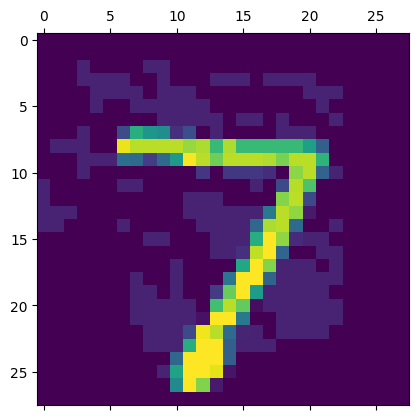

In [ ]:
# 改変前のX_testに対するスコアを表示する
preds = victim_classifier.predict(X_test)
acc = np.sum(np.argmax(preds, axis=1)
             == np.argmax(y_test, axis=1)) / len(y_test)
print('\nAccuracy on benign test examples: {}%'.format(acc * 100))

# 攻撃手法をインポートする
from art.attacks.evasion import FastGradientMethod

attack = FastGradientMethod(estimator=victim_classifier, eps=.1)

# 攻撃の結果としてAdversarial Exampleを得る
X_test_adv = attack.generate(x=X_test)

# 改変後のX_testに対するスコアを表示する
preds = victim_classifier.predict(X_test_adv)
acc = np.sum(np.argmax(preds, axis=1)
             == np.argmax(y_test, axis=1)) / len(y_test)
print('\nAccuracy on adversarial test examples: {}%'.format(acc * 100))

# 生成したAdversarial Exampleをプロットする
from matplotlib import pyplot as plt
plt.matshow(X_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

上記コードによって、人間にとっては７に見えるけれど、ニューラルネットには７には見えない、Adversarial Exampleが生成されます。

#### Section1-3-1. Carlini & Wagner Attack
Carlini & Wagner Attackは、[L-BFGS Attack](https://github.com/AmineDiro/Adversarial-Attacks)という手法の発展版です。

In [ ]:
# 攻撃手法をインポートする
from art.attacks.evasion.carlini import CarliniL2Method

# ターゲット型攻撃だが、ランダムなターゲットを指定することもできる
from art.utils import random_targets

# ここではL2ノルム最小化を試みる
attack = CarliniL2Method(classifier=victim_classifier,
                         targeted=True,
                         max_iter=10)
params = {'y': random_targets(y_test, victim_classifier.nb_classes)}

# 攻撃の結果としてAdversarial Exampleを得る
X_test_adv = attack.generate(x=X_test, **params)

C&W L_2:   0%|          | 0/10000 [00:00<?, ?it/s]

#### Section1-3-2. ZOO Attack
確率的座標勾配法という手法を用いて、計算を効率化している発展型。  
Carlini & Wagner Attackと同様のAdverisarial Exampleをブラックボックス攻撃として生成することができるものです。  
ARTから、Zoo Attackを呼び出して、今度はニューラルネットではなく、原理的に勾配を得られないモデルに対しても勾配近似による攻撃が成り立つことを確認するべく、LightGBNを攻撃対象とします。

In [ ]:
import lightgbm as lgb

# ラッパーおよびユーティリティをインポートする
from art.estimators.classification import LightGBMClassifier
from art.utils import load_mnist

# MNISTデータセットをロードする
(X_train, y_train), (X_test, y_test), \
    min_pixel_value, max_pixel_value = load_mnist()

# 今回は5枚の画像にのみ摂動を加える
X_test = X_test[0:5]
y_test = y_test[0:5]

nb_samples_train = X_train.shape[0]
nb_samples_test = X_test.shape[0]
X_train = X_train.reshape((nb_samples_train, 28 * 28))
X_test = X_test.reshape((nb_samples_test, 28 * 28))

# 攻撃対象のモデルを訓練する
params = {'objective': 'multiclass',
          'metric': 'multi_logloss',
          'num_class': 10}

lgb_train = lgb.Dataset(X_train, label=np.argmax(y_train, axis=1))
lgb_test = lgb.Dataset(X_test, label=np.argmax(y_test, axis=1))
model = lgb.train(params=params, train_set=lgb_train, num_boost_round=100, 
                  valid_sets=[lgb_test])

victim_classifier = LightGBMClassifier(model=model,
                                       clip_values=(min_pixel_value, max_pixel_value))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.401587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109606
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 629
[LightGBM] [Info] Start training from score -2.315501
[LightGBM] [Info] Start training from score -2.185988
[LightGBM] [Info] Start training from score -2.309610
[LightGBM] [Info] Start training from score -2.280987
[LightGBM] [Info] Start training from score -2.329271
[LightGBM] [Info] Start training from score -2.404064
[LightGBM] [Info] Start training from score -2.316346
[LightGBM] [Info] Start training from score -2.259366
[LightGBM] [Info] Start training from score -2.327732
[LightGBM] [Info] Start training from score -2.311121
[1]	valid_0's multi_logloss: 1.50048
[2]	valid_0's multi_logloss: 1.23327
[3]	valid_0's multi_logloss

In [ ]:
# 攻撃手法をインポートする
from art.attacks.evasion import ZooAttack

attack = ZooAttack(classifier=victim_classifier,
                   confidence=0.5,
                   targeted=False,
                   learning_rate=1e-1,
                   max_iter=200,
                   binary_search_steps=100,
                   initial_const=1e-1,
                   nb_parallel=250,
                   batch_size=1,
                   variable_h=0.01)

# 攻撃の結果としてAdversarial Exampleを得る
X_test_adv = attack.generate(x=X_test)

ZOO:   0%|          | 0/5 [00:00<?, ?it/s]

#### Section1-3-3. Adversarial Training

In [ ]:
# MNISTデータセットをロードする
(X_train, y_train), (X_test, y_test), \
    min_pixel_value, max_pixel_value = load_mnist()

nb_classes=10

# 攻撃対象のモデルを定義する
model = Sequential()
model.add(Conv2D(1,kernel_size=(7, 7), activation='relu', 
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

victim_classifier = KerasClassifier(model,
                                    clip_values=(0, 1), 
                                    use_logits=False)
victim_classifier.fit(X_train, y_train, nb_epochs=5, batch_size=128)

attack = FastGradientMethod(estimator=victim_classifier, eps=.1)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 34us/sample - loss: 0.6318 - accuracy: 0.7980
Epoch 2/5
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3913 - accuracy: 0.8806
Epoch 3/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.3608 - accuracy: 0.8900
Epoch 4/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.3400 - accuracy: 0.8968
Epoch 5/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.3294 - accuracy: 0.8999


In [ ]:
# 防御手法をインポートする
from art.defences.trainer.adversarial_trainer import AdversarialTrainer

adv_tranier = AdversarialTrainer(victim_classifier, attack)
adv_tranier.fit(X_train, y_train, batch_size=100, nb_epochs=2)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/2 [00:00<?, ?it/s]

#### Section1-3-4. Randomized Smoothing
Adversarial Trainingは概ね機能しますが、未知の攻撃手法には対処できない点を解消したものがRandomized Smoothingになります。



*   訓練されたデータにガウジアンノイズを加えて、データセットを拡張する
*   拡張したデータセットを用いてベース分類器を訓練する
*   訓練済みの分類器から『平滑化された』分類器を訓練する



In [ ]:
# TensorflowのEager Execution機能をオンオフするため、Jupyterのカーネルを再起動する
# 「すべてのセルを実行」などで複数セルを実行している場合、手動で以降のセルから再開する必要がある
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# ラッパーおよびユーティリティをインポートする
from art.estimators.classification.keras import KerasClassifier
from art.utils import load_mnist

# MNISTデータセットをロードする
(X_train, y_train), (X_test, y_test), \
    min_pixel_value, max_pixel_value = load_mnist()

nb_classes=10

# 攻撃対象のモデルを定義する
model = Sequential()
model.add(Conv2D(1,kernel_size=(7, 7), activation='relu', 
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

上記でベース分類器を作成したので、このベース分類器をもとに『平滑化された』分類器を訓練します。

In [ ]:
# ARTのRandomized SmoothingはTensorFlow 2の利用を前提とする
from art.estimators.certification.randomized_smoothing \
import TensorFlowV2RandomizedSmoothing
# 訓練用のパラメータを定義する
nb_classes=10
nb_epochs = 40
batch_size = 128
input_shape = X_train.shape[1:]
alpha = 0.001
sample_size = 100

# TensorFlowのパラメータ更新用関数を定義する
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
def train_step(model, images, labels):        
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

100%|██████████| 40/40 [05:18<00:00,  7.96s/it]


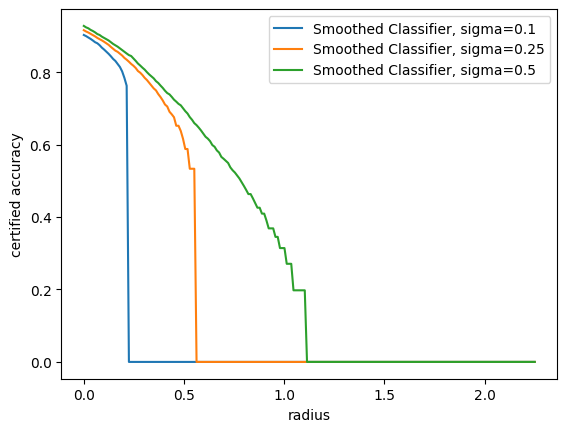

In [ ]:
from matplotlib import pyplot as plt

# 異なる分散のガウシアンノイズを定義する
sigmas = {
    'Smoothed Classifier, sigma=0.1': 0.1,
    'Smoothed Classifier, sigma=0.25': 0.25,
    'Smoothed Classifier, sigma=0.5': 0.5
}
classifiers = {}

def get_cert_acc(radius, pred, y_test):

    rad_list = np.linspace(0, 2.25, 201)
    cert_acc = []
    num_cert = len(np.where(radius > 0)[0])
    
    for r in rad_list:
        rad_idx = np.where(radius > r)[0]
        y_test_subset = y_test[rad_idx]
        cert_acc.append(np.sum(pred[rad_idx] == \
                               np.argmax(y_test_subset, axis=1)) / num_cert)
        
    return cert_acc

for name in sigmas:
    sigma = sigmas[name]

    # 「平滑化された」分類器を訓練する
    classifier = \
    TensorFlowV2RandomizedSmoothing(model=model,
                                    nb_classes=nb_classes,
                                    input_shape=input_shape,
                                    loss_object=loss_object,
                                    train_step=train_step,
                                    channels_first=False,
                                    clip_values=(min_pixel_value, 
                                                 max_pixel_value),
                                    sample_size=sample_size,
                                    scale=sigma,
                                    alpha=alpha)

    classifier.fit(X_train, y_train, nb_epochs=nb_epochs,
                   batch_size=batch_size)
    
    # Certified Accuracyを取得する
    cert_preds, radius = classifier.certify(X_test, n=500)
    
    # 半径ごとにCertified Accuracyをプロットする
    rad_list = np.linspace(0, 2.25, 201)
    plt.plot(rad_list, get_cert_acc(radius, cert_preds, y_test),
             label=name)

    classifiers[name] = classifier

plt.xlabel('radius')
plt.ylabel('certified accuracy')
plt.legend()
plt.show()

各分類器のCertified Accuracyを縦軸、半径Rを横軸に可視化しました。
『平滑化された』分類器が、定義される半径Rのどこの範囲まで、最も可能性高く予測結果を返すことができるか（つまり、うまく騙せるか）が確認できます。
ベース分類器をガウジアンノイズを加えたパンダの画像を与え、その予測結果をスコア順にソートした時、『パンダ』、『ネコ』、『イヌ』の順になったとして、直感的には、このスコアの順序はノイズの加減を多少変えたところで順序に影響はない。このスコアの順序が変わらない範囲において、分類器は正しいとするのが、Randomized Smoothingの考え方になります。

### Section1-4. BadNets

In [ ]:
# TensorflowのEager Execution機能をオンオフするため、Jupyterのカーネルを再起動する
# 「すべてのセルを実行」などで複数セルを実行している場合、手動で以降のセルから再開する必要がある
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam

# ラッパーおよびユーティリティをインポートする
from art.estimators.classification.keras import KerasClassifier
from art.utils import load_mnist, preprocess

# MNISTデータセットをロードする
# 今回は正規化される前のデータを加工するため、raw=Trueとする
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw), \
    min_pixel_value, max_pixel_value = load_mnist(raw=True)
nb_classes=10

# 攻撃手法をインポートする
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd

# 画像の右下にトリガーを埋め込む
max_val = np.max(X_train_raw)
def add_modification(x):
    return add_pattern_bd(x, pixel_value=max_val)

# データセットを汚染する
def poison_dataset(X_clean, y_clean, percent_poison, poison_func):
    X_poison = np.copy(X_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(nb_classes)
    targets=(np.arange(nb_classes) + 1) % nb_classes

    # 訓練データから汚染対象のデータを選択し、ノイズを加える
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt)
                           / (1 - percent_poison))

        src_imgs = X_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, 
                                                  num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])

        # 攻撃を初期化する
        attack = PoisoningAttackBackdoor(add_modification)
        
        # 攻撃を実行する
        imgs_to_be_poisoned, poison_labels = \
        attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        
        X_poison = np.append(X_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, X_poison, y_poison
    
# 訓練データの33%を汚染する
percent_poison = .33

(is_poison_train, X_poisoned_train_raw, y_poisoned_train_raw) = \
poison_dataset(X_train_raw, y_train_raw, percent_poison, add_modification)
X_train, y_train = preprocess(X_poisoned_train_raw, y_poisoned_train_raw)
X_train = np.expand_dims(X_train, axis=3)

(is_poison_test, X_poisoned_test_raw, y_poisoned_test_raw) = \
poison_dataset(X_test_raw, y_test_raw, percent_poison, add_modification)
X_test, y_test = preprocess(X_poisoned_test_raw, y_poisoned_test_raw)
X_test = np.expand_dims(X_test, axis=3)

# 訓練データをシャッフルする
n_train = len(y_train)
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [ ]:
# 攻撃対象のモデルを定義する
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss=categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

victim_classifier = KerasClassifier(model,
                                    clip_values=(0, 1), 
                                    use_logits=False)
# 汚染されたデータでモデルを訓練する
victim_classifier.fit(X_train, y_train, nb_epochs=30, batch_size=128)

# 汚染されていないデータに対するスコアを表示する
clean_X_test = X_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = victim_classifier.predict(clean_X_test)
acc = np.sum(np.argmax(clean_preds, axis=1)
    == np.argmax(clean_y_test, axis=1)) / len(clean_y_test)
print('\nAccuracy on clean test examples: {}%'.format(acc * 100))

# 汚染されたデータに対するスコアを表示する
poison_X_test = X_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = victim_classifier.predict(poison_X_test)
acc = np.sum(np.argmax(poison_preds, axis=1)
    == np.argmax(poison_y_test, axis=1)) / len(poison_y_test)
print('\nAccuracy on poisoned test examples: {}%'.format(acc * 100))

# データ全体に対するスコアを表示する
clean_correct = np.sum(np.argmax(clean_preds, axis=1) 
                       == np.argmax(clean_y_test, axis=1))
poison_correct = np.sum(np.argmax(poison_preds, axis=1)
                        == np.argmax(poison_y_test, axis=1))
total_correct = clean_correct + poison_correct
total = len(clean_y_test) + len(poison_y_test)
total_acc = total_correct / total

print("\nOverall accuracy on test examples: {}%".format(total_acc * 100))

Train on 89553 samples
Epoch 1/30
89553/89553 [==============================] - 10s 109us/sample - loss: 0.4063 - accuracy: 0.8703
Epoch 2/30
89553/89553 [==============================] - 7s 78us/sample - loss: 0.2063 - accuracy: 0.9396
Epoch 3/30
89553/89553 [==============================] - 8s 84us/sample - loss: 0.1874 - accuracy: 0.9450
Epoch 4/30
89553/89553 [==============================] - 7s 78us/sample - loss: 0.1753 - accuracy: 0.9478
Epoch 5/30
89553/89553 [==============================] - 8s 84us/sample - loss: 0.1619 - accuracy: 0.9522
Epoch 6/30
89553/89553 [==============================] - 7s 78us/sample - loss: 0.1658 - accuracy: 0.9511
Epoch 7/30
89553/89553 [==============================] - 8s 85us/sample - loss: 0.1600 - accuracy: 0.9538
Epoch 8/30
89553/89553 [==============================] - 7s 78us/sample - loss: 0.1514 - accuracy: 0.9553
Epoch 9/30
89553/89553 [==============================] - 8s 84us/sample - loss: 0.1544 - accuracy: 0.9553
Epoch 10/30


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Accuracy on clean test examples: 98.6%

Accuracy on poisoned test examples: 98.31472081218274%

Overall accuracy on test examples: 98.50586264656617%


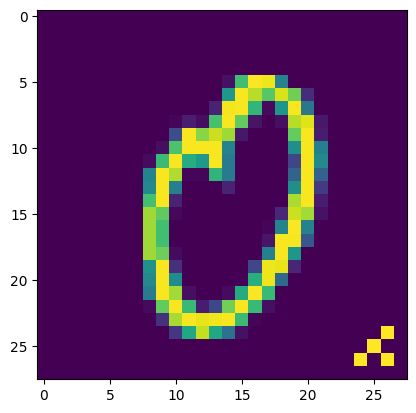

Prediction: 1


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

c = 1 # プロット対象のクラス
i = 0 # 画像の添字

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i]

plt.imshow(poison_X_test[c_idx].squeeze())
plt.show()

print('Prediction: {}'.format(np.argmax(poison_preds[c_idx])))

### Activation Clustering

/usr/local/lib/python3.10/dist-packages/art/defences/detector/poison/clustering_analyzer.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(all_assigned_clean), summary_poison_clusters, report


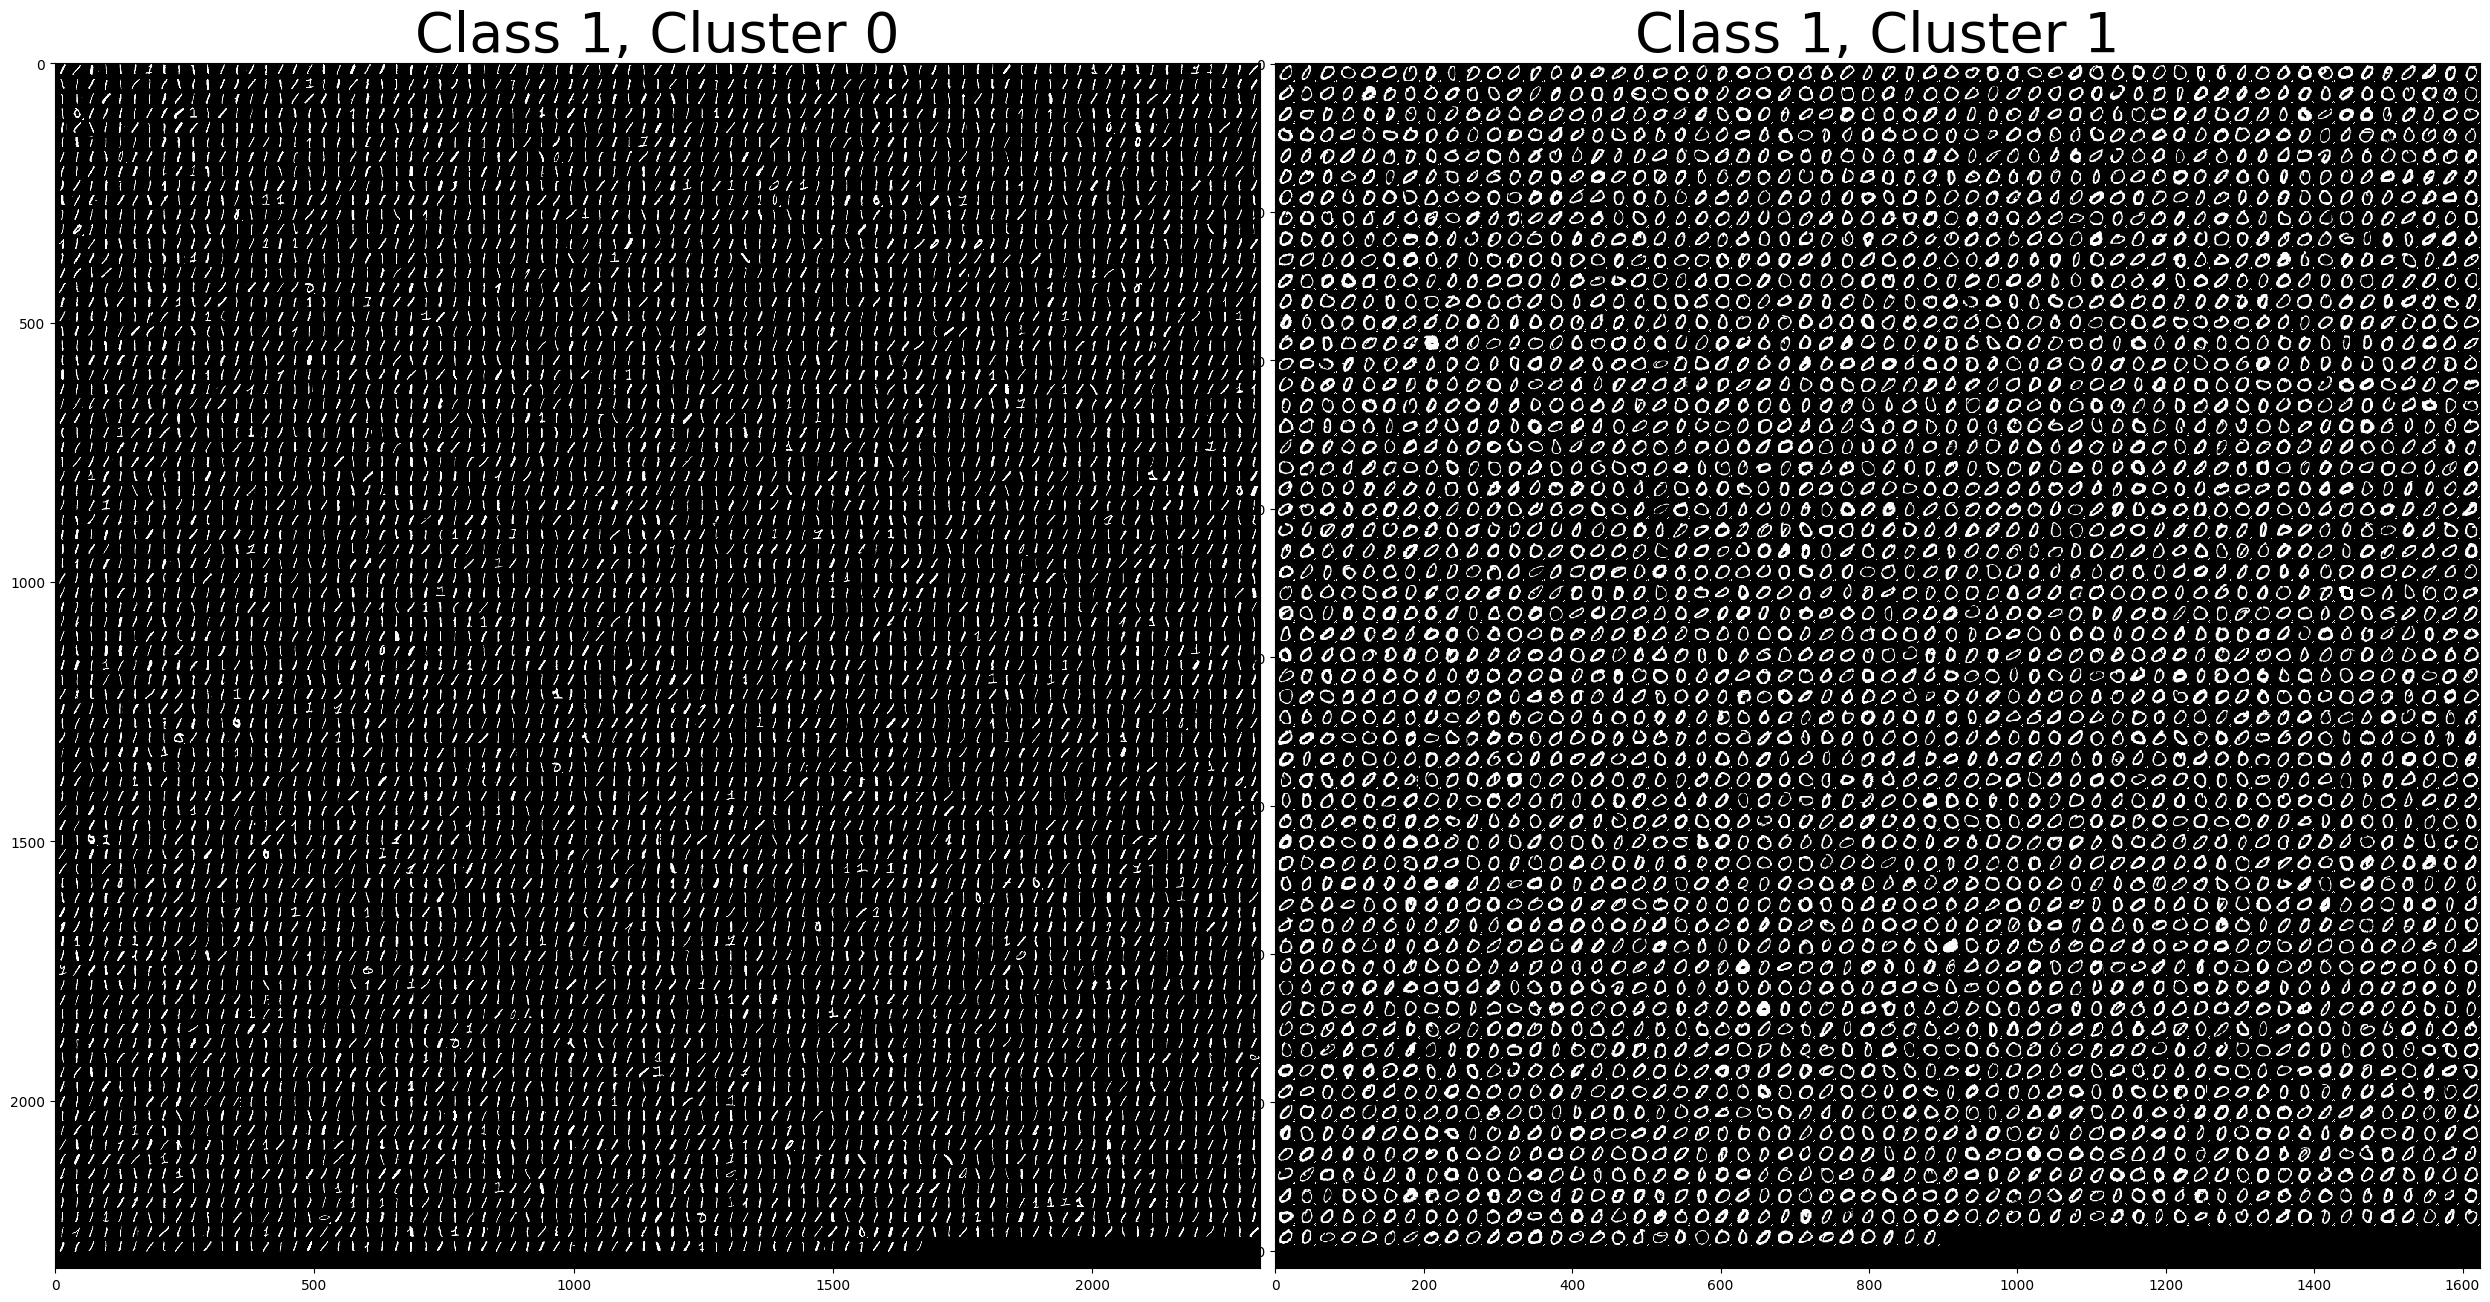

In [ ]:
# 防御手法をインポートする
from art.defences.detector.poison import ActivationDefence

defence = ActivationDefence(victim_classifier, X_train, y_train)

# PCAで次元削減を施したのち、2つのクラスタに分割する
report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce='PCA')

[clusters_by_class, _] = defence.cluster_activations()

# 指定したクラスのデータのクラスタリング結果をプロットする関数を定義する
def plot_class_clusters(sprites_by_class, n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title('Class '+ str(n_class)+ ', Cluster '+ str(q),
                  fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
# 訓練データをクラスごとに分割し、
sprites_by_class = defence.visualize_clusters(X_train, save=False)
# ここではクラス1に対するクラスタリング結果をプロットする
plot_class_clusters(sprites_by_class, 1, 2)